## 1.DATASET PREP

### libraries

In [53]:
import torch

### for loading data and data preprocessing
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, MobileViTImageProcessor
from PIL import Image
import os
import pandas as pd

### to create models and training
import torch.nn as nn
from transformers import DistilBertModel, MobileViTV2ForImageClassification
import torch.nn.functional as F

### to read the txt file output of training results
import re
import matplotlib.pyplot as plt
import numpy as np

# for testing & evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

### Custom dataset class for loading meme images and description and sentiment labels

In [ ]:
class MemeDataset(Dataset):
    """
    Dataset for loading meme images, descriptions, and sentiment labels.
    """
    def __init__(self, 
                 data_source, 
                 image_dir="meme_collection", 
                 text_column="Description", 
                 image_column="filename", 
                 label_column="Label", 
                 max_length=128):
        
        # Check if data_source is a string (file path) or DataFrame so that I can give both dataframe and csv file options
        if isinstance(data_source, str):
            self.data_df = pd.read_csv(data_source)
        else:
            self.data_df = data_source
            
        self.image_dir = image_dir
        self.text_column = text_column
        self.image_column = image_column
        self.label_column = label_column
        
        # Load tokenizer for text preprocessing, we need to use the same tokenizer as the one used in the model
        # DistilBERT is a smaller, faster, cheaper version of BERT
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_length = max_length
        
        # Load image processor for image preprocessing, we need to process images according to the MobileVIT requirements
        self.image_processor = MobileViTImageProcessor.from_pretrained('apple/mobilevitv2-1.0-imagenet1k-256')
        
        # Convert text labels to numeric 
        self.label_map = {'positive': 1, 'negative': 0, 'neutral': 2}

    # some helper functions I added to the dataset class following best practices for PyTorch Dataset clases
    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        text = self.data_df.iloc[idx][self.text_column]
        if isinstance(text, str) and '. "' in text and '" - ' in text:
            text = text.split('" - ', 1)[1]
        
        # Tokenize text
        text_encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove batch dimension added by the tokenizer
        text_encoding = {k: v.squeeze(0) for k, v in text_encoding.items()}
        
        # Get image data
        image_filename = self.data_df.iloc[idx][self.image_column]
        image_path = os.path.join(self.image_dir, image_filename)
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Provide a default blank image in case of errors
            image = Image.new('RGB', (224, 224), color='black')
        
        # Process image according to MobileVIT requirements
        image_processed = self.image_processor(images=image, return_tensors="pt")
        image_processed = image_processed['pixel_values'].squeeze(0)  # Remove batch dimension
        
        # Get label
        label_text = self.data_df.iloc[idx][self.label_column]
        # Map text label to numeric value
        if isinstance(label_text, str) and label_text.lower() in self.label_map:
            label = self.label_map[label_text.lower()]
        else:
            # Default to neutral if unknown
            label = 2
        
        label = torch.tensor(label)
        
        return {
            'input_ids': text_encoding['input_ids'],
            'attention_mask': text_encoding['attention_mask'],
            'pixel_values': image_processed,
            'label': label
        }


### dataloader class for getting traing and testing dataloaders

In [6]:
def create_data_loaders(annotations_file, image_dir="meme_collection", batch_size=16, num_workers=0, train_ratio=0.8):
    """
    Create DataLoader objects for training and testing from a single annotations file.
    
    Args:
        annotations_file (str): Path to the CSV file with annotations
        image_dir (str): Directory containing the meme images
        batch_size (int): Batch size for DataLoader
        num_workers (int): Number of workers for DataLoader
        train_ratio (float): Ratio of data to use for training (0 to 1)
        
    Returns:
        tuple: (train_loader, test_loader)
    """
    # Load the full dataset
    data = pd.read_csv(annotations_file)
    
    # Shuffle the data
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split into train and test
    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    
    # Create datasets
    train_dataset = MemeDataset(train_data, image_dir)
    test_dataset = MemeDataset(test_data, image_dir)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, test_loader

In [7]:
annotations_file = "annotations.csv"
image_dir = "meme_collection"

# Create dataloaders
train_loader, test_loader = create_data_loaders(
    annotations_file, 
    image_dir,
    batch_size=8,
    num_workers=0  # Set to 0 to avoid multiprocessing issues
)

# Print dataset stats
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Print sample batch
for batch in train_loader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention mask shape:", batch['attention_mask'].shape)
    print("Pixel values shape:", batch['pixel_values'].shape)
    print("Labels shape:", batch['label'].shape)
    break

Number of training batches: 78
Number of test batches: 20
Input IDs shape: torch.Size([8, 128])
Attention mask shape: torch.Size([8, 128])
Pixel values shape: torch.Size([8, 3, 256, 256])
Labels shape: torch.Size([8])


## 2. MODEL ARCHITECTURE FOR LATE AND EARLY FUSION

### Some notes on the model architecture 

**Q1: Why did I add conditions for 'early' and 'late' fusion modes?**  
- Different fusion strategies allow flexibility in combining modalities based on task requirements.  
  - *Early fusion*: Combines features from text and image encoders before classification, leveraging joint feature interactions for better decision-making.  
  - *Late fusion*: Processes modalities independently and averages their logits, useful when individual modality-specific predictions are desired or when modalities have varying importance.



**Q2: Why is the classifier structured differently for early and late modes?**  
- **Early Fusion**:  
  - A single classifier processes concatenated features from both text and image encoders.  
  - This approach ensures joint learning across modalities, enabling the model to capture inter-modal dependencies effectively.  

- **Late Fusion**:  
  - Separate classifiers handle text and image features independently.  
  - Logits are averaged to balance contributions from each modality, maintaining modality-specific strengths while combining predictions.



**Q3: What layers I added for early fusion and why?**  
- The layers in the early fusion classifier are designed to process high-dimensional concatenated features efficiently:  
  - **Linear Layer (text_feat_dim + image_feat_dim → 512)**: Reduces dimensionality while preserving essential information.  
  - **ReLU Activation**: Introduces non-linearity to enable complex decision boundaries.  
  - **Dropout (0.2)**: Prevents overfitting by randomly deactivating neurons during training.  
  - **Final Linear Layer (512 → num_classes)**: Maps processed features to class logits for classification tasks.


###  Fusion model class defintion

In [ ]:
class FusionModel(nn.Module):
    def __init__(self, num_classes=3, mode='early'):
        super().__init__()
        self.mode = mode
        
        # Text encoder (DistilBERT)
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.text_model.parameters():
            param.requires_grad = False
        text_feat_dim = 768  # DistilBERT hidden size

        # Image encoder (MobileViTV2)
        self.image_model = MobileViTV2ForImageClassification.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
        for param in self.image_model.parameters():
            param.requires_grad = False # direct instruction from assignment to freeze the parameters from the pretrained model
            # possible reasons: avoiding overfitting and catastrophic forgetting
        image_feat_dim = 512  # MobileViTV2 feature dimension

        # Initialize classifiers based on fusion mode
        if mode == 'early':
            self.classifier = nn.Sequential(
                nn.Linear(text_feat_dim + image_feat_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, num_classes)
            )
        elif mode == 'late':
            self.text_classifier = nn.Linear(text_feat_dim, num_classes)
            self.image_classifier = nn.Linear(image_feat_dim, num_classes)
        else:
            raise ValueError("Invalid fusion mode. Choose 'early' or 'late'") 
        # or we can introduce an enum for better type safety, like FusionType.EARLY, FisionType.LATE

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text features (CLS token)
        text_out = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_out.last_hidden_state[:, 0, :]

        # Image features (global average pooling)
        image_out = self.image_model(pixel_values)
        image_features = image_out.last_hidden_state.mean(dim=1)

        if self.mode == 'early':
            combined = torch.cat([text_features, image_features], dim=1)
            return self.classifier(combined)
            
        elif self.mode == 'late':
            text_logits = self.text_classifier(text_features)
            image_logits = self.image_classifier(image_features)
            return (text_logits + image_logits) / 2


In [9]:
# Early fusion (default)
early_fusion_model = FusionModel(mode='early')

total_params = sum(p.numel() for p in early_fusion_model.parameters())
trainable_params = sum(p.numel() for p in early_fusion_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Total parameters: 71922132
Trainable parameters: 1170411
Percentage of trainable parameters: 1.63%


In [10]:
print("Early Fusion Model:")
print(early_fusion_model)

Early Fusion Model:
FusionModel(
  (text_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [11]:
late_fusion_model = FusionModel(mode='late')


total_params = sum(p.numel() for p in late_fusion_model.parameters())
trainable_params = sum(p.numel() for p in late_fusion_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Total parameters: 71268567
Trainable parameters: 516846
Percentage of trainable parameters: 0.73%


In [12]:
print("Late Fusion Model:")
print(late_fusion_model)

Late Fusion Model:
FusionModel(
  (text_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
     

## 3. TRAINING AND OPTMIZATION

In [ ]:
def train_model(model, train_loader, num_epochs=5, lr=1e-4):
    """
    Train the model without a validation loader.
    
    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs to train.
        lr (float): Learning rate for the optimizer.
    
    Returns:
        nn.Module: Trained model.
        dict: Training metrics (loss and accuracy per epoch).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # unfortunately, I don't have access to a GPU
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    metrics = {
        'train_loss': [],
        'train_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs.pop('label')

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(**inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate metrics for the epoch
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct / total

        metrics['train_loss'].append(avg_loss)
        metrics['train_acc'].append(accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_loss:.4f} | Train Acc: {accuracy:.4f}\n")

    return model, metrics


In [14]:
early_fusion_model, early_metrics = train_model(early_fusion_model, train_loader)

Epoch 1/5
Train Loss: 1.0167 | Train Acc: 0.5194

Epoch 2/5
Train Loss: 0.9643 | Train Acc: 0.5387

Epoch 3/5
Train Loss: 0.9332 | Train Acc: 0.5629

Epoch 4/5
Train Loss: 0.8941 | Train Acc: 0.5790

Epoch 5/5
Train Loss: 0.8502 | Train Acc: 0.6258



In [15]:
early_fusion_model, early_metrics = train_model(early_fusion_model, train_loader, num_epochs=200, lr=1e-4)

Epoch 1/200
Train Loss: 0.8292 | Train Acc: 0.6113

Epoch 2/200
Train Loss: 0.7991 | Train Acc: 0.6484

Epoch 3/200
Train Loss: 0.7733 | Train Acc: 0.6677

Epoch 4/200
Train Loss: 0.7547 | Train Acc: 0.6710

Epoch 5/200
Train Loss: 0.7412 | Train Acc: 0.6629

Epoch 6/200
Train Loss: 0.7177 | Train Acc: 0.6952

Epoch 7/200
Train Loss: 0.7045 | Train Acc: 0.7000

Epoch 8/200
Train Loss: 0.6852 | Train Acc: 0.7177

Epoch 9/200
Train Loss: 0.6636 | Train Acc: 0.7339

Epoch 10/200
Train Loss: 0.6484 | Train Acc: 0.7306

Epoch 11/200
Train Loss: 0.6497 | Train Acc: 0.7371

Epoch 12/200
Train Loss: 0.6281 | Train Acc: 0.7371

Epoch 13/200
Train Loss: 0.6482 | Train Acc: 0.7226

Epoch 14/200
Train Loss: 0.5970 | Train Acc: 0.7726

Epoch 15/200
Train Loss: 0.5867 | Train Acc: 0.7694

Epoch 16/200
Train Loss: 0.5824 | Train Acc: 0.7613

Epoch 17/200
Train Loss: 0.5897 | Train Acc: 0.7597

Epoch 18/200
Train Loss: 0.5411 | Train Acc: 0.7855

Epoch 19/200
Train Loss: 0.5704 | Train Acc: 0.7645

Ep

### plot for training performance of early fusion model

In [ ]:
def plot_training_metrics(file_path):
    # Parse the file
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extract epoch, loss, and accuracy data
    pattern = r"Epoch (\d+)/\d+\nTrain Loss: ([\d\.]+) \| Train Acc: ([\d\.]+)"
    matches = re.findall(pattern, content)
    
    epochs = [int(match[0]) for match in matches]
    losses = [float(match[1]) for match in matches]
    accuracies = [float(match[2]) for match in matches]
    
    # Display summary statistics
    print(f"Epochs analyzed: {len(epochs)}")
    print(f"Initial loss: {losses[0]:.4f}, Final loss: {losses[-1]:.4f}")
    print(f"Loss reduction: {losses[0] - losses[-1]:.4f} ({(1 - losses[-1]/losses[0])*100:.2f}%)")
    print(f"Initial accuracy: {accuracies[0]:.4f}, Final accuracy: {accuracies[-1]:.4f}")
    print(f"Accuracy improvement: {accuracies[-1] - accuracies[0]:.4f} ({(accuracies[-1]/accuracies[0] - 1)*100:.2f}%)")
    
    # Create plot
    plt.figure(figsize=(12, 5))
    
    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'b-', marker='o', markersize=4)
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add trendline
    z = np.polyfit(epochs, losses, 1)
    p = np.poly1d(z)
    plt.plot(epochs, p(epochs), "r--", alpha=0.7)
    
    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'g-', marker='o', markersize=4)
    plt.title('Training Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add trendline
    z = np.polyfit(epochs, accuracies, 1)
    p = np.poly1d(z)
    plt.plot(epochs, p(epochs), "r--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Epochs analyzed: 200
Initial loss: 0.8292, Final loss: 0.0791
Loss reduction: 0.7501 (90.46%)
Initial accuracy: 0.6113, Final accuracy: 0.9823
Accuracy improvement: 0.3710 (60.69%)


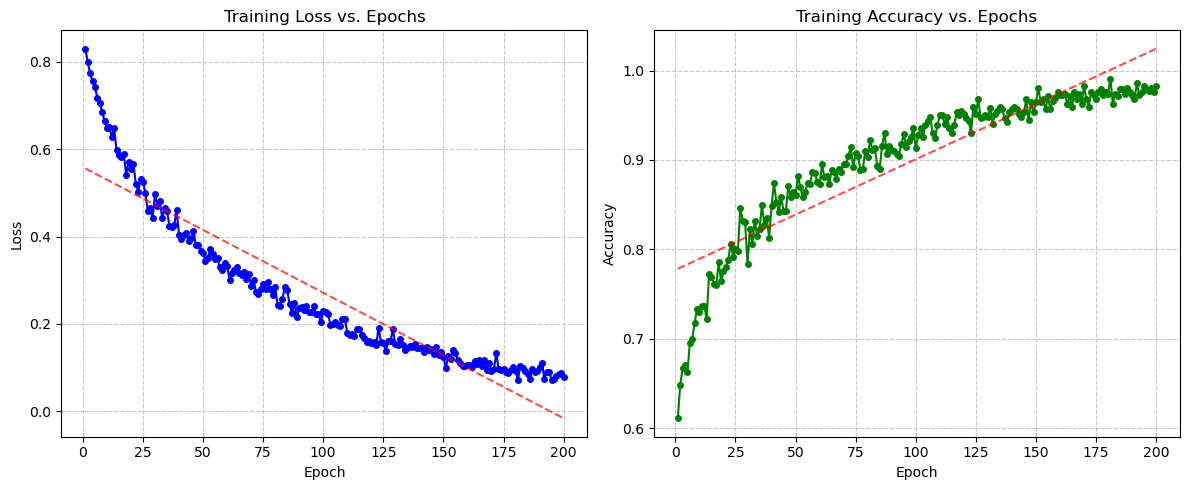

In [19]:
plot_training_metrics('early_fusion_output.txt')

In [ ]:
late_fusion_model, early_metrics = train_model(late_fusion_model, train_loader, num_epochs=10, lr=1e-4)

Epoch 1/10
Train Loss: 1.0900 | Train Acc: 0.3984

Epoch 2/10
Train Loss: 1.0191 | Train Acc: 0.5323

Epoch 3/10
Train Loss: 1.0076 | Train Acc: 0.5323

Epoch 4/10
Train Loss: 0.9966 | Train Acc: 0.5323

Epoch 5/10
Train Loss: 0.9960 | Train Acc: 0.5323

Epoch 6/10
Train Loss: 0.9859 | Train Acc: 0.5323

Epoch 7/10
Train Loss: 0.9779 | Train Acc: 0.5323

Epoch 8/10
Train Loss: 0.9728 | Train Acc: 0.5339

Epoch 9/10
Train Loss: 0.9717 | Train Acc: 0.5339

Epoch 10/10
Train Loss: 0.9576 | Train Acc: 0.5355



In [26]:
early_fusion_model_short = FusionModel(mode='early')
early_fusion_model_short, early_metrics_short = train_model(early_fusion_model_short, train_loader, num_epochs=10, lr=1e-4)

Epoch 1/10
Train Loss: 1.0185 | Train Acc: 0.5290

Epoch 2/10
Train Loss: 0.9697 | Train Acc: 0.5371

Epoch 3/10
Train Loss: 0.9289 | Train Acc: 0.5548

Epoch 4/10
Train Loss: 0.8838 | Train Acc: 0.5871

Epoch 5/10
Train Loss: 0.8485 | Train Acc: 0.6258

Epoch 6/10
Train Loss: 0.8379 | Train Acc: 0.6258

Epoch 7/10
Train Loss: 0.7967 | Train Acc: 0.6516

Epoch 8/10
Train Loss: 0.7574 | Train Acc: 0.6742

Epoch 9/10
Train Loss: 0.7521 | Train Acc: 0.6855

Epoch 10/10
Train Loss: 0.7155 | Train Acc: 0.6968



### comparision between models for first 10 epochs

Epochs analyzed: 10
Initial loss: 1.0900, Final loss: 0.9576
Loss reduction: 0.1324 (12.15%)
Initial accuracy: 0.3984, Final accuracy: 0.5355
Accuracy improvement: 0.1371 (34.41%)


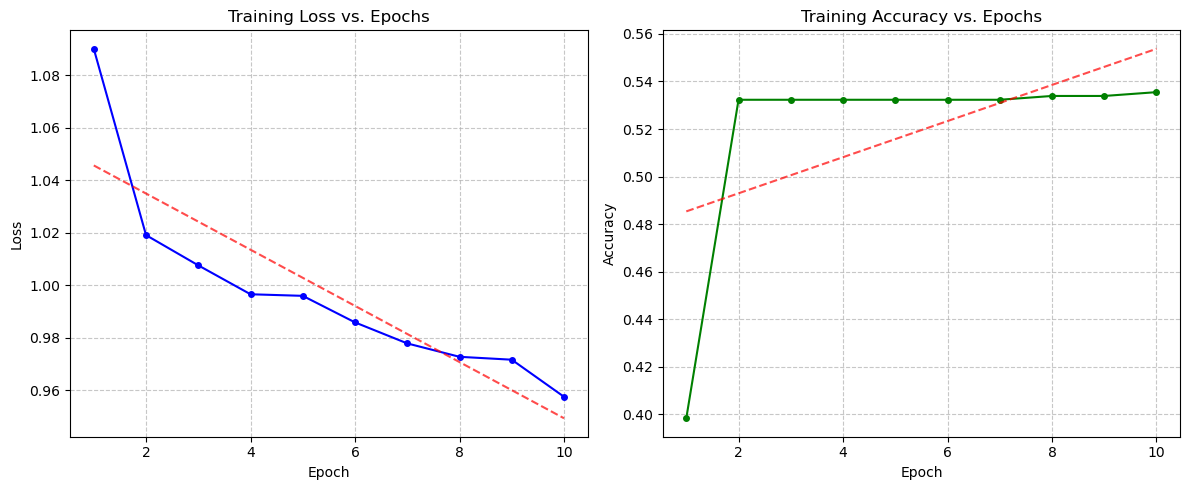

In [23]:
plot_training_metrics('late_fusion_output.txt')

Epochs analyzed: 10
Initial loss: 0.8292, Final loss: 0.6484
Loss reduction: 0.1808 (21.80%)
Initial accuracy: 0.6113, Final accuracy: 0.7306
Accuracy improvement: 0.1193 (19.52%)


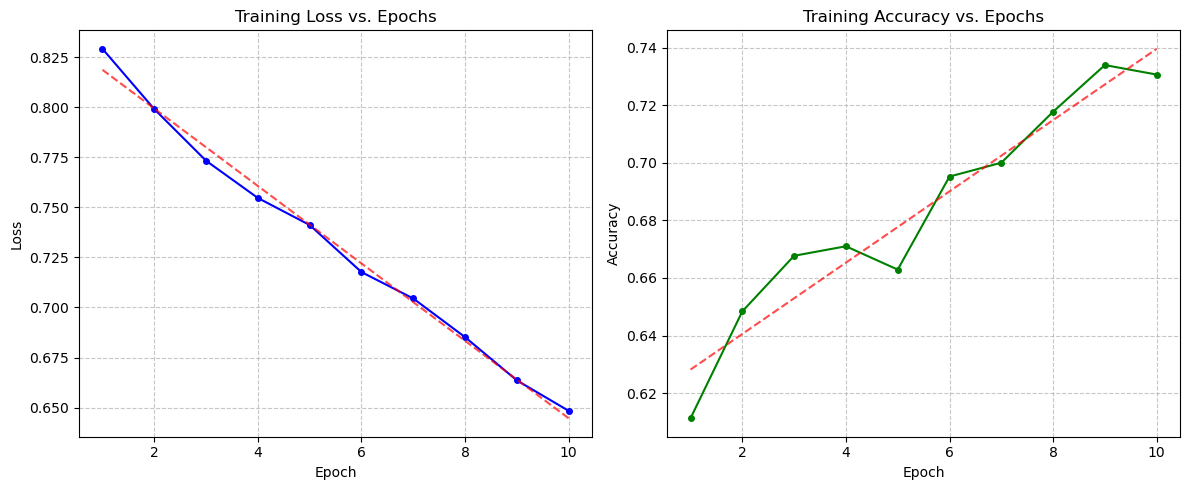

In [24]:
plot_training_metrics('early_fusion_output_short.txt')

## 4. TESTING

In [28]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval() # important to set the model to evaluation mode so that dropout layers are disabled
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs.pop('label')
            
            # Forward pass
            outputs = model(**inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect predictions and labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Get classification report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'classification_report': class_report,
        'labels': all_labels,
        'predictions': all_preds
    }


In [29]:
test_model(early_fusion_model, test_loader)

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


{'accuracy': 0.6730769230769231,
 'f1_score': 0.6739943773730473,
 'classification_report': {'0': {'precision': 0.8148148148148148,
   'recall': 0.5365853658536586,
   'f1-score': 0.6470588235294118,
   'support': 41.0},
  '1': {'precision': 0.4594594594594595,
   'recall': 0.5666666666666667,
   'f1-score': 0.5074626865671642,
   'support': 30.0},
  '2': {'precision': 0.717391304347826,
   'recall': 0.7764705882352941,
   'f1-score': 0.7457627118644068,
   'support': 85.0},
  'accuracy': 0.6730769230769231,
  'macro avg': {'precision': 0.6638885262073667,
   'recall': 0.6265742069185398,
   'f1-score': 0.6334280739869943,
   'support': 156.0},
  'weighted avg': {'precision': 0.6933939234663872,
   'recall': 0.6730769230769231,
   'f1-score': 0.6739943773730473,
   'support': 156.0}},
 'labels': [2,
  1,
  2,
  0,
  2,
  0,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  0,
  2,
  1,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  0,
  1,
  2,
  2,

In [30]:
test_model(early_fusion_model_short, test_loader)

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


{'accuracy': 0.6410256410256411,
 'f1_score': 0.5996839359494297,
 'classification_report': {'0': {'precision': 0.75,
   'recall': 0.36585365853658536,
   'f1-score': 0.4918032786885246,
   'support': 41.0},
  '1': {'precision': 0.6363636363636364,
   'recall': 0.23333333333333334,
   'f1-score': 0.34146341463414637,
   'support': 30.0},
  '2': {'precision': 0.624,
   'recall': 0.9176470588235294,
   'f1-score': 0.7428571428571429,
   'support': 85.0},
  'accuracy': 0.6410256410256411,
  'macro avg': {'precision': 0.6701212121212121,
   'recall': 0.5056113502311493,
   'f1-score': 0.525374612059938,
   'support': 156.0},
  'weighted avg': {'precision': 0.659493006993007,
   'recall': 0.6410256410256411,
   'f1-score': 0.5996839359494297,
   'support': 156.0}},
 'labels': [2,
  1,
  2,
  0,
  2,
  0,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  0,
  2,
  1,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  0,
  1,
  2,
  2,
  2,
  1,
  1,
  0,
  1,

In [31]:
test_model(late_fusion_model, test_loader)

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

{'accuracy': 0.5448717948717948,
 'f1_score': 0.38434939887222047,
 'classification_report': {'0': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 41.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30.0},
  '2': {'precision': 0.5448717948717948,
   'recall': 1.0,
   'f1-score': 0.7053941908713693,
   'support': 85.0},
  'accuracy': 0.5448717948717948,
  'macro avg': {'precision': 0.18162393162393162,
   'recall': 0.3333333333333333,
   'f1-score': 0.23513139695712312,
   'support': 156.0},
  'weighted avg': {'precision': 0.2968852728468113,
   'recall': 0.5448717948717948,
   'f1-score': 0.38434939887222047,
   'support': 156.0}},
 'labels': [2,
  1,
  2,
  0,
  2,
  0,
  2,
  2,
  2,
  1,
  2,
  2,
  1,
  0,
  2,
  1,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  2,
  1,
  2,
  2,
  2,
  0,
  2,
  0,
  2,
  0,
  1,
  2,
  2,
  2,
  1,
  1,
  0,
  1,
  0,
  0,
  2,
  2,
  2,
  2,
  2,
  0,
  2,
  1,
  1,
  0,
  2,
  2,
  2,
  1,
  2

In [43]:
from torch.utils.data import Subset, DataLoader


def test_model(model, test_dataset, batch_size=8, first_n_samples=75):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Create subset of test dataset with first_n_samples
    test_subset = Subset(test_dataset, range(first_n_samples))
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            labels = inputs.pop('label')
            
            # Forward pass
            outputs = model(**inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect predictions, probabilities and labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    
    # Get classification report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate per-class metrics
    classes = sorted(np.unique(all_labels))
    per_class_metrics = {}
    
    for i, cls in enumerate(classes):
        cls_indices = (all_labels == cls)
        cls_correct = (all_preds[cls_indices] == cls).sum()
        cls_total = cls_indices.sum()
        cls_accuracy = cls_correct / cls_total if cls_total > 0 else 0
        
        # Precision, recall from classification report
        precision = class_report[str(cls)]['precision']
        recall = class_report[str(cls)]['recall']
        f1 = class_report[str(cls)]['f1-score']
        
        # Calculate confidence (mean probability for correct predictions)
        correct_indices = np.logical_and(cls_indices, all_preds == cls)
        if correct_indices.sum() > 0:
            mean_confidence = np.mean(all_probs[correct_indices, cls])
        else:
            mean_confidence = 0
            
        per_class_metrics[cls] = {
            'accuracy': cls_accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': cls_total,
            'mean_confidence': mean_confidence
        }
    
    # Calculate overall confidence
    correct_indices = (all_labels == all_preds)
    mean_confidence = np.mean([all_probs[i, pred] for i, pred in enumerate(all_preds) if correct_indices[i]])
    
    # Create statistics summary
    stats_summary = {
        'accuracy': accuracy,
        'f1_score': {
            'weighted': f1_weighted,
            'macro': f1_macro,
            'micro': f1_micro
        },
        'per_class': per_class_metrics,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'mean_confidence': mean_confidence,
        'total_samples': len(all_labels),
        'correct_samples': correct_indices.sum(),
        'misclassified_samples': len(all_labels) - correct_indices.sum()
    }
    
    return stats_summary

In [48]:
def test_model(model, test_loader):
    """
    Evaluate the model using a DataLoader directly.
    
    Args:
        model (nn.Module): The trained model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        
    Returns:
        dict: Dictionary containing comprehensive evaluation metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(**inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect predictions, probabilities and labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    
    # Get classification report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate per-class metrics
    classes = sorted(np.unique(all_labels))
    per_class_metrics = {}
    
    for i, cls in enumerate(classes):
        cls_indices = (all_labels == cls)
        cls_correct = (all_preds[cls_indices] == cls).sum()
        cls_total = cls_indices.sum()
        cls_accuracy = cls_correct / cls_total if cls_total > 0 else 0
        
        # Precision, recall from classification report
        precision = class_report[str(cls)]['precision'] if str(cls) in class_report else 0
        recall = class_report[str(cls)]['recall'] if str(cls) in class_report else 0
        f1 = class_report[str(cls)]['f1-score'] if str(cls) in class_report else 0
        
        # Calculate confidence (mean probability for correct predictions)
        correct_indices = np.logical_and(cls_indices, all_preds == cls)
        if correct_indices.sum() > 0:
            mean_confidence = np.mean(all_probs[correct_indices, cls])
        else:
            mean_confidence = 0
            
        per_class_metrics[cls] = {
            'accuracy': cls_accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': cls_total,
            'mean_confidence': mean_confidence
        }
    
    # Calculate overall confidence
    correct_indices = (all_labels == all_preds)
    mean_confidence = np.mean([all_probs[i, pred] for i, pred in enumerate(all_preds) if correct_indices[i]])
    
    # Create statistics summary
    stats_summary = {
        'accuracy': accuracy,
        'f1_score': {
            'weighted': f1_weighted,
            'macro': f1_macro,
            'micro': f1_micro
        },
        'per_class': per_class_metrics,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'mean_confidence': mean_confidence,
        'total_samples': len(all_labels),
        'correct_samples': correct_indices.sum(),
        'misclassified_samples': len(all_labels) - correct_indices.sum()
    }
    
    return stats_summary

In [54]:
early_fusion_dict = test_model(early_fusion_model, test_loader)
early_fusion_dict

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


{'accuracy': 0.6730769230769231,
 'f1_score': {'weighted': 0.6739943773730473,
  'macro': 0.6334280739869943,
  'micro': 0.6730769230769231},
 'per_class': {0: {'accuracy': 0.5365853658536586,
   'precision': 0.8148148148148148,
   'recall': 0.5365853658536586,
   'f1_score': 0.6470588235294118,
   'support': 41,
   'mean_confidence': 0.85372996},
  1: {'accuracy': 0.5666666666666667,
   'precision': 0.4594594594594595,
   'recall': 0.5666666666666667,
   'f1_score': 0.5074626865671642,
   'support': 30,
   'mean_confidence': 0.89952457},
  2: {'accuracy': 0.7764705882352941,
   'precision': 0.717391304347826,
   'recall': 0.7764705882352941,
   'f1_score': 0.7457627118644068,
   'support': 85,
   'mean_confidence': 0.9265766}},
 'confusion_matrix': array([[22,  6, 13],
        [ 0, 17, 13],
        [ 5, 14, 66]]),
 'classification_report': {'0': {'precision': 0.8148148148148148,
   'recall': 0.5365853658536586,
   'f1-score': 0.6470588235294118,
   'support': 41.0},
  '1': {'precision

In [55]:
early_fusion_short_dict = test_model(early_fusion_model_short, test_loader)
early_fusion_short_dict

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


{'accuracy': 0.6410256410256411,
 'f1_score': {'weighted': 0.5996839359494297,
  'macro': 0.525374612059938,
  'micro': 0.6410256410256411},
 'per_class': {0: {'accuracy': 0.36585365853658536,
   'precision': 0.75,
   'recall': 0.36585365853658536,
   'f1_score': 0.4918032786885246,
   'support': 41,
   'mean_confidence': 0.59636515},
  1: {'accuracy': 0.23333333333333334,
   'precision': 0.6363636363636364,
   'recall': 0.23333333333333334,
   'f1_score': 0.34146341463414637,
   'support': 30,
   'mean_confidence': 0.5270203},
  2: {'accuracy': 0.9176470588235294,
   'precision': 0.624,
   'recall': 0.9176470588235294,
   'f1_score': 0.7428571428571429,
   'support': 85,
   'mean_confidence': 0.72638613}},
 'confusion_matrix': array([[15,  1, 25],
        [ 1,  7, 22],
        [ 4,  3, 78]]),
 'classification_report': {'0': {'precision': 0.75,
   'recall': 0.36585365853658536,
   'f1-score': 0.4918032786885246,
   'support': 41.0},
  '1': {'precision': 0.6363636363636364,
   'recall':

In [56]:
late_fusion_dict = test_model(late_fusion_model, test_loader)
late_fusion_dict

Error loading image meme_collection/u_jelly.jpg: Image size (200900000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

{'accuracy': 0.5448717948717948,
 'f1_score': {'weighted': 0.38434939887222047,
  'macro': 0.23513139695712312,
  'micro': 0.5448717948717948},
 'per_class': {0: {'accuracy': 0.0,
   'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 41,
   'mean_confidence': 0},
  1: {'accuracy': 0.0,
   'precision': 0.0,
   'recall': 0.0,
   'f1_score': 0.0,
   'support': 30,
   'mean_confidence': 0},
  2: {'accuracy': 1.0,
   'precision': 0.5448717948717948,
   'recall': 1.0,
   'f1_score': 0.7053941908713693,
   'support': 85,
   'mean_confidence': 0.5514125}},
 'confusion_matrix': array([[ 0,  0, 41],
        [ 0,  0, 30],
        [ 0,  0, 85]]),
 'classification_report': {'0': {'precision': 0.0,
   'recall': 0.0,
   'f1-score': 0.0,
   'support': 41.0},
  '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 30.0},
  '2': {'precision': 0.5448717948717948,
   'recall': 1.0,
   'f1-score': 0.7053941908713693,
   'support': 85.0},
  'accuracy': 0.5448717948717948,
  '

### Comparing performance between early and late fusion models

In [ ]:
def plot_model_comparison(early_fusion_dict, early_fusion_short_dict, late_fusion_dict):
    model_dicts = [early_fusion_dict, early_fusion_short_dict, late_fusion_dict]
    model_names = ['Early Fusion', 'Early Fusion Short', 'Late Fusion']
    
    # Overall metrics
    accuracy = [d['accuracy'] for d in model_dicts]
    f1_weighted = [d['f1_score']['weighted'] for d in model_dicts]
    f1_macro = [d['f1_score']['macro'] for d in model_dicts]
    
    # Per-class F1 scores
    classes = sorted(early_fusion_dict['per_class'].keys())
    class_f1_scores = []
    
    for cls in classes:
        class_f1 = []
        for d in model_dicts:
            if cls in d['per_class'] and d['per_class'][cls]['f1_score'] is not None:
                class_f1.append(d['per_class'][cls]['f1_score'])
            else:
                class_f1.append(0)  # Handle missing classes
        class_f1_scores.append(class_f1)
    
    # Mean confidence
    mean_confidence = [d.get('mean_confidence', 0) for d in model_dicts]
    
    # Confusion matrices
    confusion_matrices = [d['confusion_matrix'] for d in model_dicts]
    
    # Plot 1: Overall Performance Metrics
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.bar(x - width, accuracy, width, label='Accuracy', color='#4C72B0')
    plt.bar(x, f1_weighted, width, label='F1 (Weighted)', color='#55A868')
    plt.bar(x + width, f1_macro, width, label='F1 (Macro)', color='#C44E52')
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Overall Performance Comparison')
    plt.xticks(x, model_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, v in enumerate(accuracy):
        plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(f1_weighted):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(f1_macro):
        plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Per-Class F1 Scores
    plt.subplot(2, 1, 2)
    
    bar_width = 0.25
    r1 = np.arange(len(model_names))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, class_f1_scores[0], width=bar_width, label=f'Class {classes[0]} F1', color='#4C72B0')
    plt.bar(r2, class_f1_scores[1], width=bar_width, label=f'Class {classes[1]} F1', color='#55A868')
    plt.bar(r3, class_f1_scores[2], width=bar_width, label=f'Class {classes[2]} F1', color='#C44E52')
    
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('Per-Class F1 Score Comparison')
    plt.xticks([r + bar_width for r in range(len(model_names))], model_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Confidence plot
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, mean_confidence, color=['#4C72B0', '#55A868', '#C44E52'])
    plt.xlabel('Models')
    plt.ylabel('Mean Confidence')
    plt.title('Model Confidence Comparison')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, v in enumerate(mean_confidence):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('model_confidence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Confusion matrices
    plt.figure(figsize=(15, 5))
    
    for i, (cm, name, cmap) in enumerate(zip(confusion_matrices, 
                                             model_names, 
                                             ['Blues', 'Greens', 'Reds'])):
        plt.subplot(1, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False,
                    xticklabels=[f'Class {c}' for c in classes],
                    yticklabels=[f'Class {c}' for c in classes])
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create summary table
    data = {
        'Model': model_names,
        'Accuracy': [f'{a:.4f}' for a in accuracy],
        'F1 (Weighted)': [f'{f1:.4f}' for f1 in f1_weighted],
        'F1 (Macro)': [f'{f1:.4f}' for f1 in f1_macro]
    }
    
    for i, cls in enumerate(classes):
        data[f'Class {cls} F1'] = [f'{f1:.4f}' for f1 in class_f1_scores[i]]
    
    data['Mean Confidence'] = [f'{c:.4f}' for c in mean_confidence]
    
    df = pd.DataFrame(data)
    print("Model Performance Summary Table:")
    print(df.to_string(index=False))
    
    return df

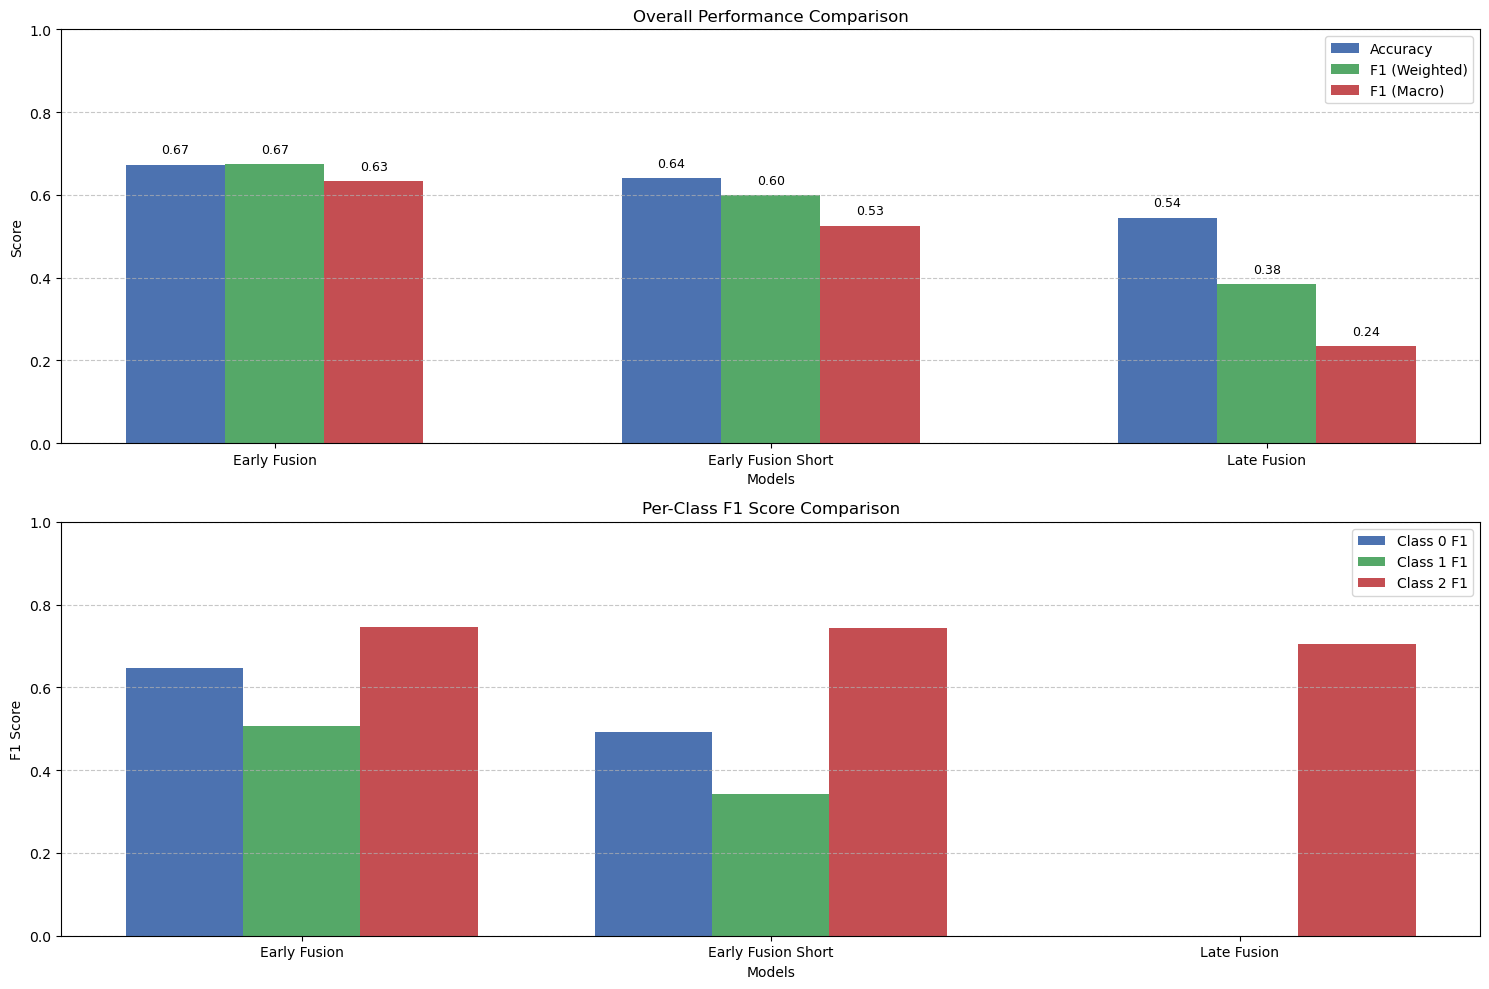

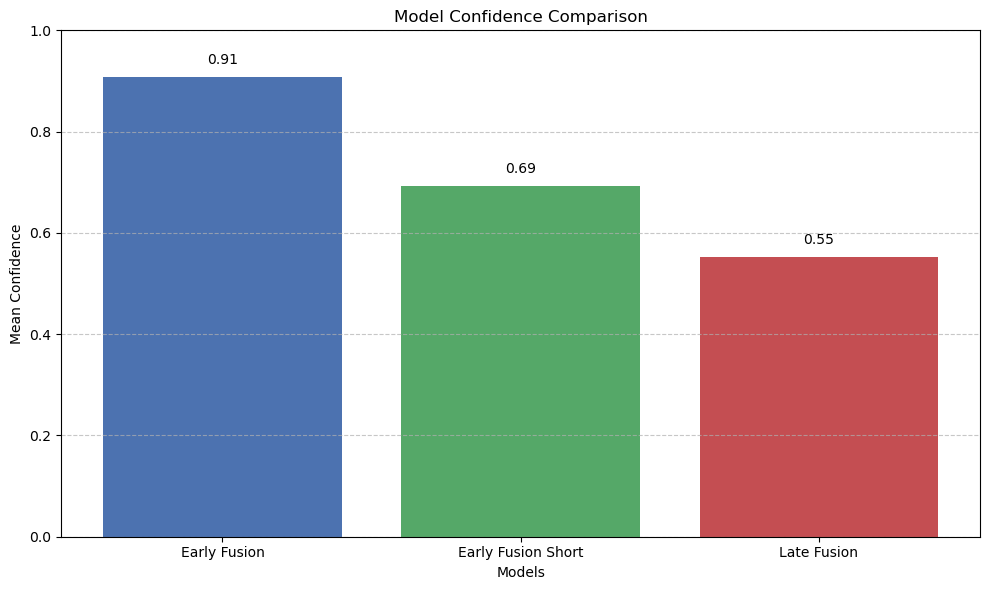

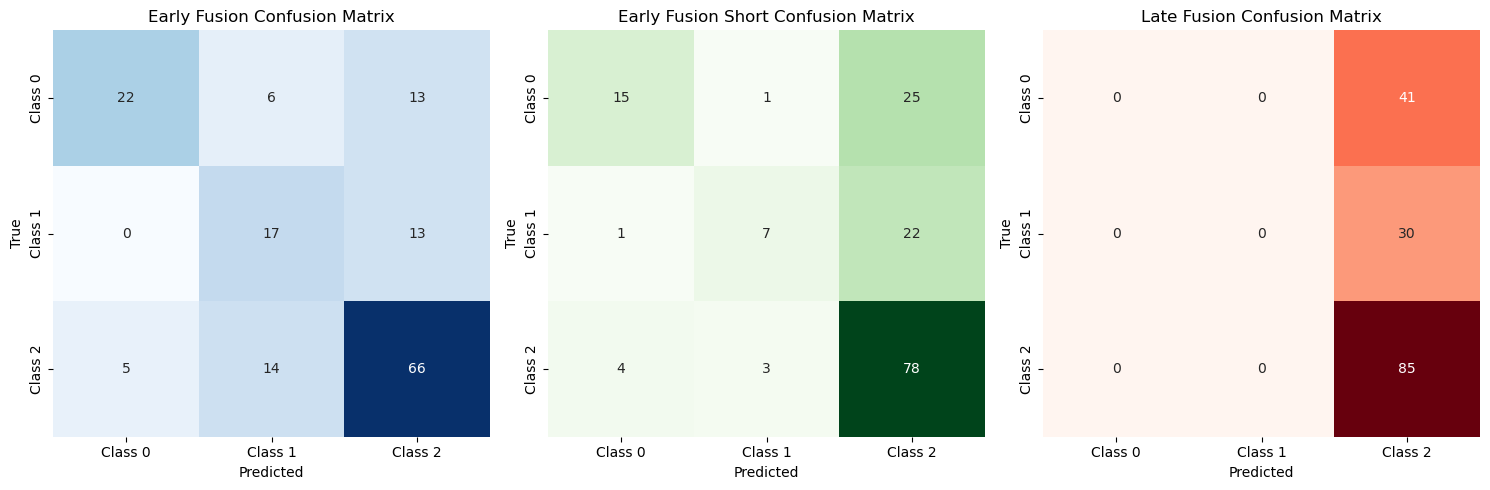

Model Performance Summary Table:
             Model Accuracy F1 (Weighted) F1 (Macro) Class 0 F1 Class 1 F1 Class 2 F1 Mean Confidence
      Early Fusion   0.6731        0.6740     0.6334     0.6471     0.5075     0.7458          0.9069
Early Fusion Short   0.6410        0.5997     0.5254     0.4918     0.3415     0.7429          0.6929
       Late Fusion   0.5449        0.3843     0.2351     0.0000     0.0000     0.7054          0.5514


In [57]:
summary_df = plot_model_comparison(early_fusion_dict, early_fusion_short_dict, late_fusion_dict)

### for the first 10 epochs

- Early Fusion Short: 64.10% accuracy, 59.97% weighted F1 score
- Late Fusion: 54.49% accuracy, 38.43% weighted F1 score
- Early Fusion Short outperforms Late Fusion by ~10% in accuracy and ~22% in weighted F1 score


### early fusion short (10 epochs) and early fusion (200 epochs)
The standard Early Fusion model also outperformed the "short" variant:

- Higher accuracy (67.31% vs 64.10%)
- Better performance on minority classes (particularly classes 0 and 1)
- More confident predictions (90.69% vs 69.29%)

This suggests that more training was beneficial for capturing more nuanced relationships between the modalities

### why was late fusion less performant?
- Early fusion's approach of learning joint representations between text and image modalities is more effective for the task than late fusion's approach of combining independent predictions. 
- Late fusion appears to have degraded to essentially a majority-class classifier, only predicting class 2 (which has the most samples). This suggests it failed to learn meaningful patterns from either modality independently.



## UNGRADED WORK

### Future updates: 

If i had more time, I would have hoped to look into these use cases for overall better model

1. Type safety using enums

    Right now, I am passing arguments as 'early' and 'late' for different fusion models, using enums would have helped with typos

2. Data parallelism

    I had some problem connecting with TACC at the time of me working on this assignment, I wish I used Pytorch Lightening to divide the data into n parts, train the base model on n different parts of data parallely and take the average of the weights after all n models are finished training ([source](https://towardsdatascience.com/deep-learning-at-scale-parallel-model-training-d7c22904b5a4/)), which would have speeded up the training process

3. Expermenting with hyperparameters (batch size, epoch, learning rate)

    Ideally, I want a batch size large enough to avoid noisy updates and a related epoch count ([source](https://www.reddit.com/r/MachineLearning/s/KzLz688d5g))

4. Gradual unfreezing
    [source](https://ericwiener.github.io/ai-notes/AI-Notes/Definitions/Gradual-Unfreezing)

### Lessions learnt

1. Underestimating training will take less time because of freezing parameters of pretrained models, it still took me more than 2 hours to train the early fusion model for 200 epochs, convergence happened, writing some dynamic epoch adjustment or validation set would have helped tremendously!

### adding some helper code that helped me decide a few things

### trying out different methods from given models

In [1]:
from transformers import MobileViTImageProcessor, MobileViTV2ForImageClassification
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = MobileViTImageProcessor.from_pretrained("shehan97/mobilevitv2-1.0-imagenet1k-256")
model = MobileViTV2ForImageClassification.from_pretrained("shehan97/mobilevitv2-1.0-imagenet1k-256")

inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits

# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


/opt/homebrew/anaconda3/envs/multimodal-systems/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Predicted class: tabby, tabby cat


### determining image size for MobileViTV2ForImageClassification model 

In [2]:
image_feat_dim = model.classifier.in_features
print(f"Image feature dimension: {image_feat_dim}")

Image feature dimension: 512
